In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras import regularizers

In [15]:
import pandas as pd
df = pd.read_csv("/kaggle/input/BNREEL_text.csv")
df

,file_id,class,text,source,category
0,1000188341415358,Safe,Me on my way to watch Oppenheimer After Berbie,Facebook,Safe
1,1006146964533997,Safe,[NULL],Facebook,Safe
2,1007123741459823,Adult,বান্ধবী আমার লাগানির পিনিকে আছে Love in love,Facebook,Unsafe
3,1007420607202244,Safe,প্রত্যেকটা অফিসে এমন একজন কলিগ থাকবেই Laptop,Facebook,Safe
4,1008519870870927,Safe,হ্যালো শার্ক ট্যাঙ্ক বাংলাদেশ আই এম কামিং,Facebook,Safe
...,...,...,...,...,...
1916,3356285208118215619_62841927222,Safe,The amount of comfort this scene gives >>,Instagram,Safe
1917,3363424170779680862_62841927222_2,Safe,Anupam Roy's voice is line medicine for all br...,Instagram,Safe
1918,3363424170779680862_62841927222_3,Safe,Anupam Roy's voice is line medicine for all br...,Instagram,Safe
1919,3363424170779680862_62841927222_,Safe,Anupam Roy's voice is line medicine for all br...,Instagram,Safe


In [16]:
df = df[df['category']=='Unsafe']

In [17]:
df['class'].value_counts()

class
Adult       467
Harmful     321
Suicidal    276
Name: count, dtype: int64

In [18]:
df['class'], uniques = pd.factorize(df['class'])
uniques

<ipython-input-18-03e9cba94263>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class'], uniques = pd.factorize(df['class'])


Index(['Adult', 'Harmful', 'Suicidal'], dtype='object')

In [26]:
dir1 = "/kaggle/input/Audio_V1/Audio_V1"
dir2 = "/kaggle/input/Audio_V2/Audio_V2"
dir3 = "/kaggle/input/UNBER_IG/UNBER_IG/Audio_IG"

In [21]:
pip install noisereduce --quiet

Note: you may need to restart the kernel to use updated packages.


In [22]:
import os
import numpy as np
import pandas as pd
import librosa
import noisereduce as nr
import soundfile as sf

In [23]:
def process_audio_file(file_path, target_length=15, sample_rate=22050, n_mfcc=13, n_chroma=12, 
                       n_spectral_contrast=6, target_length_features=20):
    # Load audio file
    audio, sr = librosa.load(file_path, sr=sample_rate)

    # Trim or pad audio to target length
    target_samples = target_length * sr
    if len(audio) > target_samples:
        audio = audio[:target_samples]  # Trim
    else:
        padding = target_samples - len(audio)
        audio = np.pad(audio, (0, padding), mode='constant')  # Pad with silence

    # Normalize audio (zero mean, unit variance)
    mean = np.mean(audio)
    std = np.std(audio)
    safe_std = max(std, 1e-8)  # Avoid division by zero
    audio = (audio - mean) / safe_std

    # Apply noise reduction
    reduced_noise_audio = nr.reduce_noise(y=audio, sr=sr)

    if not np.isfinite(reduced_noise_audio).all():
        print("Warning: Noise reduction produced NaN/Inf values, reverting to original audio.")
        reduced_noise_audio = audio  # Use original if noise reduction fails
    
    reduced_noise_audio = np.nan_to_num(reduced_noise_audio)

    # Feature Extraction
    def truncate_or_pad(feature, target_length_features):
        """Ensures features have a fixed length by truncating or padding."""
        if feature.shape[1] > target_length_features:
            return feature[:, :target_length_features]
        else:
            return np.pad(feature, ((0, 0), (0, target_length_features - feature.shape[1])), mode='constant')

    # Extract MFCCs (13 coefficients)
    mfcc = librosa.feature.mfcc(y=reduced_noise_audio, sr=sr, n_mfcc=n_mfcc)
    mfcc = truncate_or_pad(mfcc, target_length_features)

    # Extract Chroma Features (12 pitch classes)
    chroma = librosa.feature.chroma_stft(y=reduced_noise_audio, sr=sr, n_chroma=n_chroma)
    chroma = truncate_or_pad(chroma, target_length_features)

    # Extract Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=reduced_noise_audio, sr=sr)
    spectral_centroid = truncate_or_pad(spectral_centroid, target_length_features)

    # Extract Spectral Contrast (6 bands)
    spectral_contrast = librosa.feature.spectral_contrast(y=reduced_noise_audio, sr=sr, n_bands=n_spectral_contrast)
    spectral_contrast = truncate_or_pad(spectral_contrast, target_length_features)

    # Extract Spectrogram (Magnitude Spectrogram)
    spectrogram = np.abs(librosa.stft(reduced_noise_audio))
    spectrogram = truncate_or_pad(spectrogram, target_length_features)

    # Flatten all features into a single vector
    feature_vector = np.concatenate([
        mfcc.flatten(),
        chroma.flatten(),
        spectral_centroid.flatten(),
        spectral_contrast.flatten(),
        spectrogram.flatten()
    ])

    return feature_vector

In [41]:
X = []
y = []

In [42]:
for _, row in df.iterrows():
    reel_id = row["file_id"]
    label = row["class"]  

    for dir in list([dir1, dir2, dir3]):
        audio_file = os.path.join(dir, f"{reel_id}.wav")
        if os.path.exists(audio_file): 
            processed_audio = process_audio_file(audio_file)      
            X.append(processed_audio)
            y.append(label)

/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:70: RuntimeWarning: divide by zero encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:70: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [43]:
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

(1056, 21160)
(1056,)


In [44]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [45]:
X = np.expand_dims(X, axis=-1)

In [46]:
X.shape

(1056, 21160, 1)

In [47]:
import numpy as np

combined = list(zip(X, y))

np.random.shuffle(combined)

X, y = zip(*combined)

X = np.array(X)
y = np.array(y)

In [48]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [49]:
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1),
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=3, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu', 
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    Dropout(0.3),

    Dense(3, activation='softmax')  # binary
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [61]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

In [63]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=4,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.7320 - loss: 1.0856 - val_accuracy: 0.6038 - val_loss: 2.0333 - learning_rate: 1.0000e-05
Epoch 2/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7864 - loss: 1.0401 - val_accuracy: 0.5000 - val_loss: 1.8715 - learning_rate: 1.0000e-05
Epoch 3/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8325 - loss: 0.8326 - val_accuracy: 0.5943 - val_loss: 1.6576 - learning_rate: 1.0000e-05
Epoch 4/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7997 - loss: 0.8504 - val_accuracy: 0.5094 - val_loss: 1.9023 - learning_rate: 1.0000e-05
Epoch 5/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8466 - loss: 0.7880 - val_accuracy: 0.5189 - val_loss: 2.0108 - learning_rate: 1.0000e-05
Epoch 6/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8356 - loss: 0.7760 - val_accuracy: 0.5377 - val_loss: 2.0545 - learning_rate: 1.0000e-05
Epoch 7/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - acc

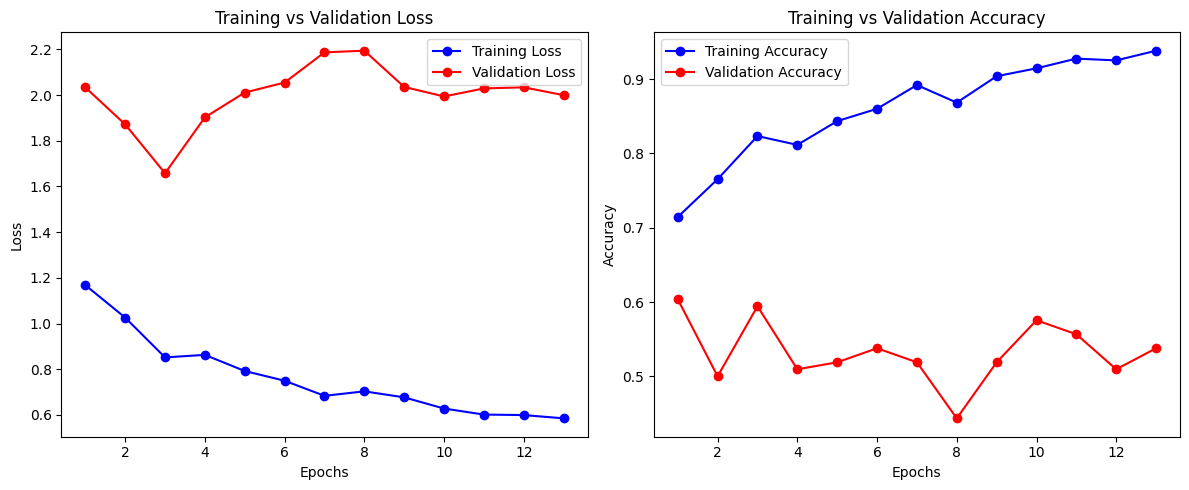

In [64]:
import matplotlib.pyplot as plt

# Extract metrics from history
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [65]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.4754 - loss: 2.1201
Test Accuracy: 0.4906


In [66]:
from sklearn.metrics import classification_report, confusion_matrix

In [67]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


In [68]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.54      0.57      0.56        47
           1       0.44      0.34      0.39        32
           2       0.45      0.52      0.48        27

    accuracy                           0.49       106
   macro avg       0.48      0.48      0.48       106
weighted avg       0.49      0.49      0.49       106



In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

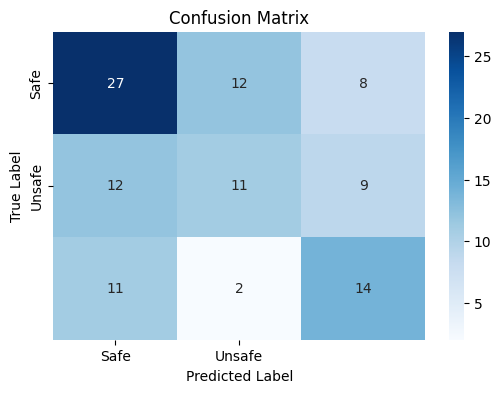

In [70]:
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Safe","Unsafe"], yticklabels=["Safe","Unsafe"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()

In [71]:
model.save('/kaggle/working/cnn_h2.keras')